In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
from numpy.lib.function_base import average
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

## Testing Data

In [4]:
test_final_sessions_df = pd.read_csv("Dataset/test_final_sessions.csv", sep=',')

In [5]:
test_final_purchases_df = pd.read_csv('Dataset/test_final_purchases.csv',sep=',')

In [6]:
candidate_items_df = pd.read_csv('Dataset/candidate_items.csv',sep= ',')

## Training Data

In [7]:
train_sessions_df = pd.read_csv("Dataset/train_sessions.csv", sep=',')
train_sessions_df

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211
...,...,...,...
4743815,4440001,20409,2020-10-30 23:37:20.658
4743816,4440001,14155,2020-10-30 23:31:56.607
4743817,4440001,14303,2020-10-30 23:36:17.934
4743818,4440001,27852,2020-10-30 23:39:55.186


In [8]:
train_purchases_df = pd.read_csv("Dataset/train_purchases.csv", sep=',')
train_purchases_df

,session_id,item_id,date
0,3,15085,2020-12-18 21:26:47.986
1,13,18626,2020-03-13 19:36:15.507
2,18,24911,2020-08-26 19:20:32.049
3,19,12534,2020-11-02 17:16:45.92
4,24,13226,2020-02-26 18:27:44.114
...,...,...,...
999995,4439986,2915,2021-05-13 11:56:37.464
999996,4439990,8786,2020-08-22 14:28:22.382
999997,4439994,21630,2020-11-27 20:10:28.961
999998,4439999,16962,2020-11-27 11:01:41.356


In [9]:
item_features_df = pd.read_csv("Dataset/item_features.csv", sep=',')
item_features_df

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75
...,...,...,...
471746,28143,68,351
471747,28143,55,390
471748,28143,11,109
471749,28143,73,91


In [10]:
print(train_sessions_df.shape)
print(train_purchases_df.shape)
print(item_features_df.shape)

(4743820, 3)
(1000000, 3)
(471751, 3)


# Data Exploration

### *General Information*

In [11]:
print("Train purchases dataframe\n")

session_ids_purchases = train_purchases_df['session_id'].unique()
item_ids_purchases = train_purchases_df['item_id'].unique()

n_sessions_purchases = len(session_ids_purchases)
n_items_purchases = len(item_ids_purchases)

print("Number of total purchases: {}".format(len(train_purchases_df)))
print("Number of unique sessions: {}".format(n_sessions_purchases))
print("Number of unique items: {}".format(n_items_purchases))
print("Min ID sessions: {}, Max ID sessions: {}".format(min(session_ids_purchases), max(session_ids_purchases)))
print("Min ID items: {}, Max ID items: {}".format(min(item_ids_purchases), max(item_ids_purchases)))

Train purchases dataframe

Number of total purchases: 1000000
Number of unique sessions: 1000000
Number of unique items: 18907
Min ID sessions: 3, Max ID sessions: 4440001
Min ID items: 3, Max ID items: 28143


In [12]:
print("Item features dataframe\n")

item_ids_features = item_features_df['item_id'].unique()

print("Number of unique items: {}".format(len(item_ids_features)))
print("Min ID items: {}, Max ID items: {}".format(min(item_ids_features), max(item_ids_features)))

Item features dataframe

Number of unique items: 23691
Min ID items: 2, Max ID items: 28143


### **Anomaly Detection**

In [13]:
print(train_sessions_df.isnull().values.any())
print(train_purchases_df.isnull().values.any())
print(item_features_df.isnull().values.any())

False
False
False


### **Features Analysis**

In [15]:
feature_category_groupby = item_features_df.groupby(['feature_category_id'])
feature_value_groupby = item_features_df.groupby(['feature_value_id'])
print('Number of Feature Categories: {}'.format(len(feature_category_groupby)))
print('Number of Feature Values: {}'.format(len(feature_value_groupby)))

Number of Feature Categories: 73
Number of Feature Values: 890


### Items distribution over Feature Categories

In [16]:
category_itemcount = item_features_df[['item_id', 'feature_category_id']].drop_duplicates().groupby(['feature_category_id']).count()
category_itemcount.rename(columns={"item_id": "item_count"}, inplace=True)

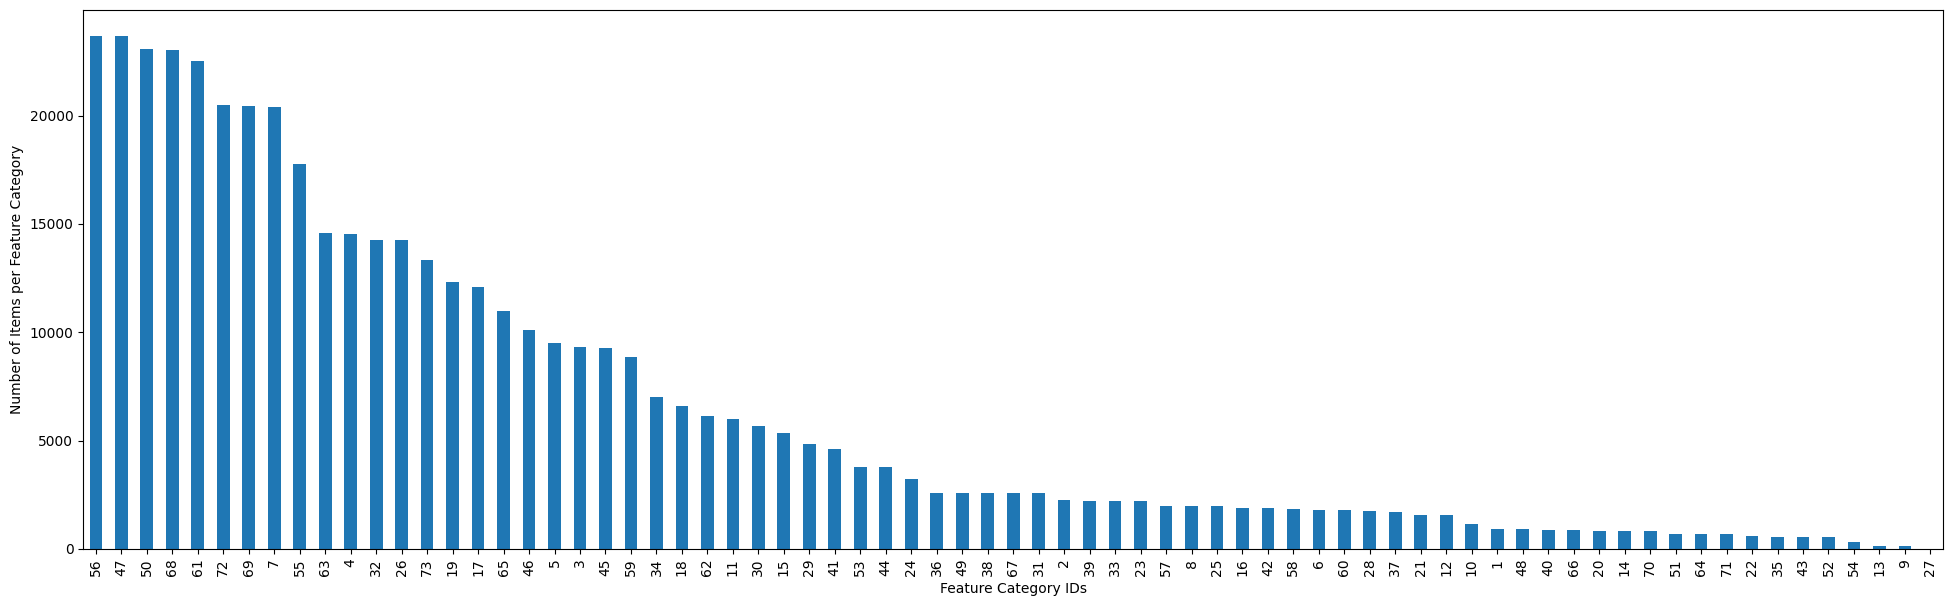

In [17]:
sorted_category_itemcount = category_itemcount['item_count'].sort_values(ascending=False)

sorted_category_itemcount.plot(kind='bar', figsize=(24,7))
plt.xlabel('Feature Category IDs')
plt.ylabel('Number of Items per Feature Category')
plt.show()

### Feature Values distribution over Feature Categories

In [18]:
category_valuecount = item_features_df[['feature_category_id', 'feature_value_id']].drop_duplicates().groupby(['feature_category_id']).count()
category_valuecount.rename(columns={"feature_value_id": "feature_value_count"}, inplace=True)

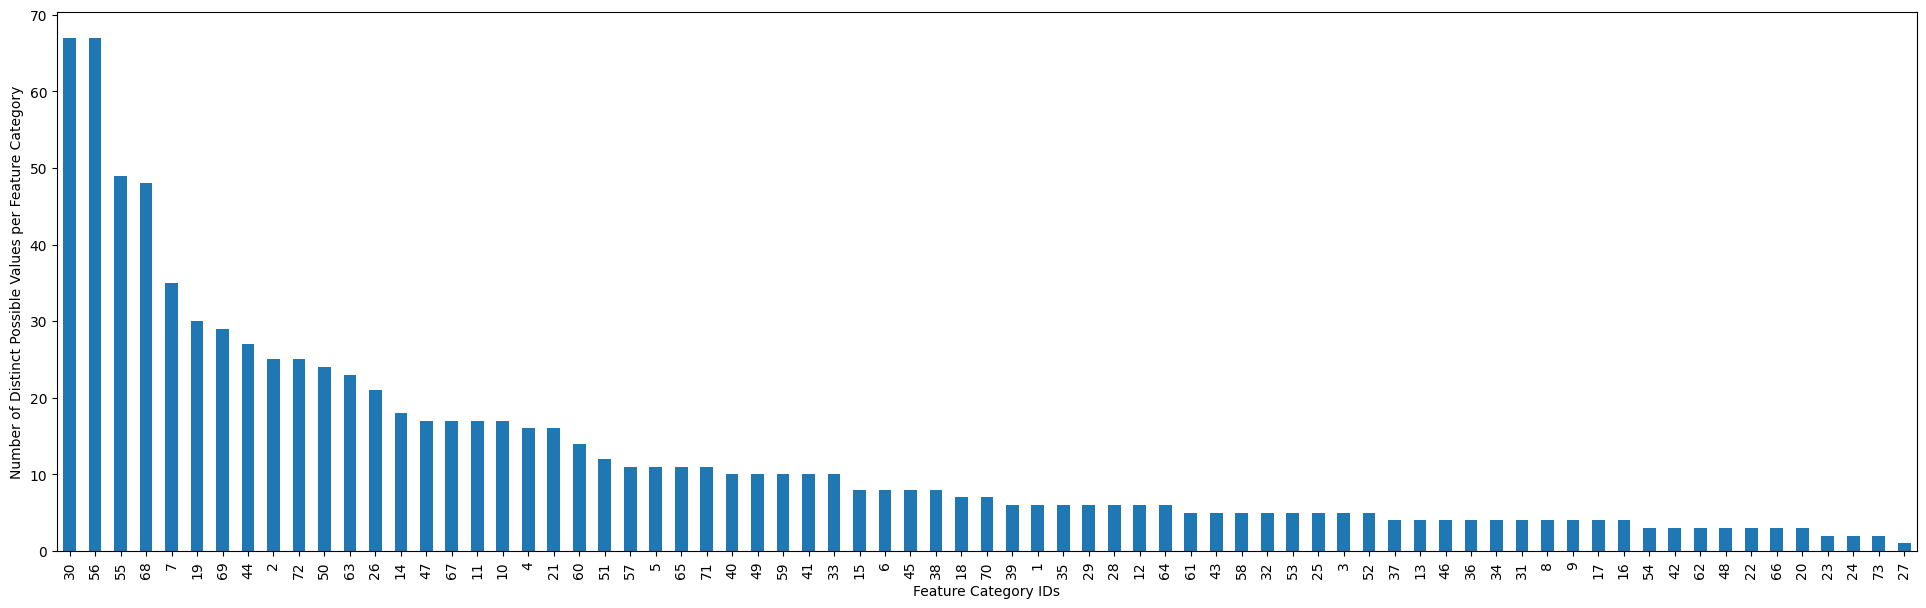

In [19]:
sorted_category_valuecount = category_valuecount['feature_value_count'].sort_values(ascending=False)

sorted_category_valuecount.plot(kind='bar', figsize=(24,7))
plt.xlabel('Feature Category IDs')
plt.ylabel('Number of Distinct Possible Values per Feature Category')
plt.show()

### Items distribution over Feature Values

In [20]:
value_itemcount = item_features_df[['item_id', 'feature_value_id']].drop_duplicates().groupby(['feature_value_id']).count()
value_itemcount.rename(columns={"item_id": "item_count"}, inplace=True)

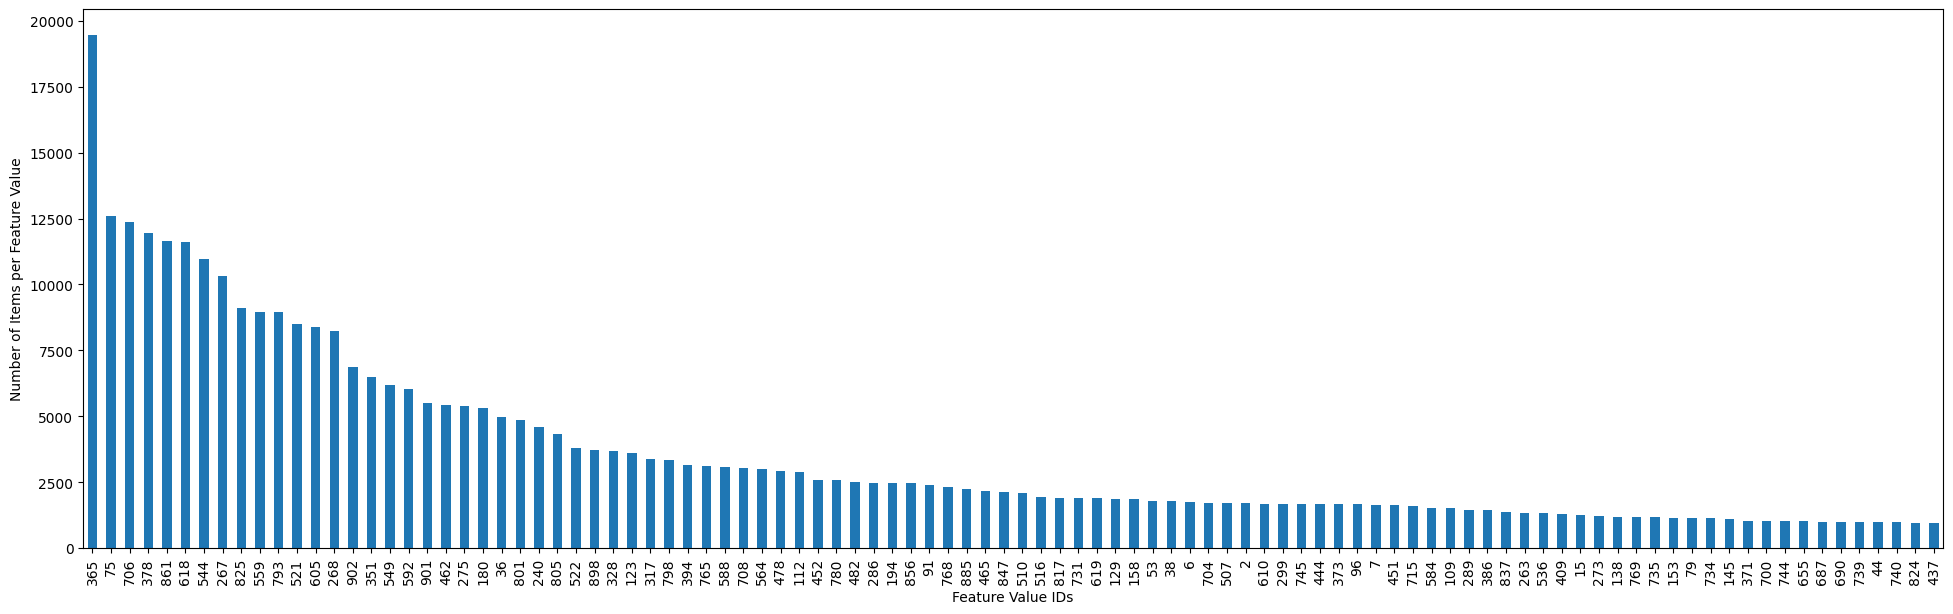

In [21]:
sorted_value_itemcount = value_itemcount['item_count'].sort_values(ascending=False)

sorted_value_itemcount[:100].plot(kind='bar', figsize=(24,7))
plt.xlabel('Feature Value IDs')
plt.ylabel('Number of Items per Feature Value')
plt.show()

### Feature Categories distribution over Items

In [22]:
value_categorycount = item_features_df[['item_id', 'feature_category_id']].drop_duplicates().groupby(['item_id']).count()
value_categorycount.rename(columns={"feature_category_id": "feature_category_count"}, inplace=True)

In [23]:
sorted_value_categorycount = value_categorycount['feature_category_count'].sort_values(ascending=False)

print('Max number of feature categories per item: {}'.format(max(value_categorycount['feature_category_count'])))
print('Min number of feature categories per item: {}'.format(min(value_categorycount['feature_category_count'])))
print('Average number of feature categories per item: {}'.format(round(np.average(value_categorycount['feature_category_count']))))

Max number of feature categories per item: 27
Min number of feature categories per item: 2
Average number of feature categories per item: 19


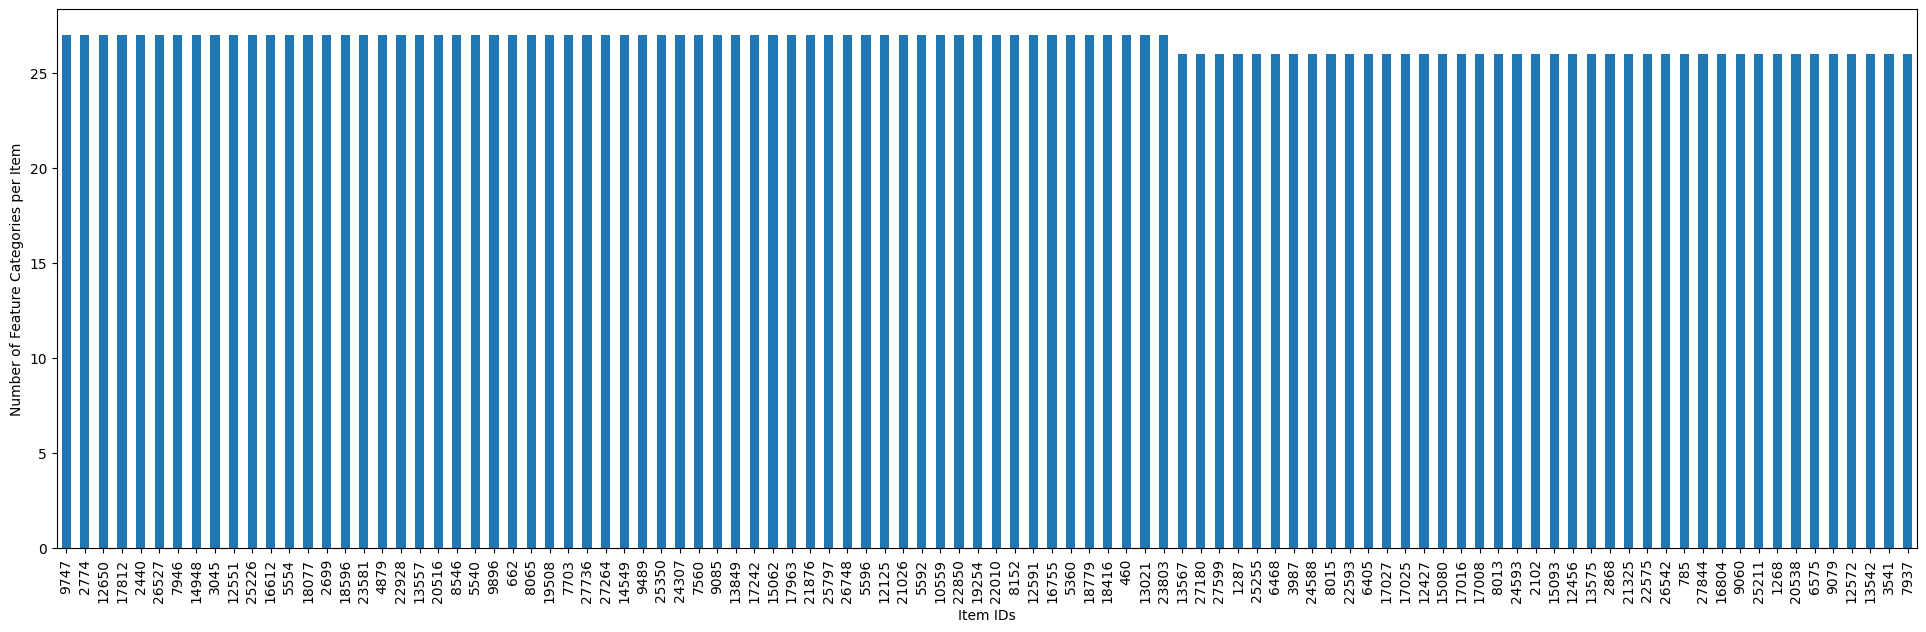

In [24]:
sorted_value_categorycount[:100].plot(kind='bar', figsize=(24,7))
plt.xlabel('Item IDs')
plt.ylabel('Number of Feature Categories per Item')
plt.show()

### Multi-category Value IDs

In [25]:
category_value_df = item_features_df[['feature_category_id', 'feature_value_id']].drop_duplicates()

# If the feature_value_id column has some repeated values, it means that a single value-id can be associated to different feature categories

if not category_value_df['feature_value_id'].is_unique:
  print('Some Value-IDs are multi-category')

Some Value-IDs are multi-category


In [26]:
multi_category_value_ids = category_value_df[category_value_df['feature_value_id'].duplicated()]['feature_value_id'].values
multi_category_value_ids

array([123,  96, 194,  36, 418, 541,  32, 752, 273, 439, 400,  39, 184,
       164], dtype=int64)

In [27]:
print(f"There are {len(multi_category_value_ids)} multi-category value IDs")

There are 14 multi-category value IDs


### **Session Analysis**

### Sessions with multiple-viewed items